In [1]:
import pandas as pd 
import numpy as np 
import pickle
import os 
from scipy.stats import norm

import time
from xgboost.sklearn import XGBRegressor
import matplotlib.pyplot as plt


In [2]:
def regional_closs(percentage_peak_strength):
    '''
    This function is developed for compute objective function corresponding to single set of value
    '''
    im_bin = [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, float('inf')]
    retrof_ratio = {}
    prop = {}
    retrof_ds_ratio = {}
    retrof_ds_median = {}

    for i in range(1,9):
        temp = pd.DataFrame() 
        temp['Index'] = existing_prop['Index']
        temp['Xpeakstrength'] = percentage_peak_strength[i-1]
        temp['Zpeakstrength'] = percentage_peak_strength[i-1]

        retrof_ratio[i] = pd.concat([temp, retrof_upper_limit]).min(level=0)
        prop[i] = existing_prop.drop(['Xpeakstrength', 'Zpeakstrength'], axis = 1)
        prop[i]['Xpeakstrength'], prop[i]['Zpeakstrength'] = retrof_ratio[i]['Xpeakstrength'].copy(), retrof_ratio[i]['Zpeakstrength'].copy()

        retrof_ds_ratio[i] = pd.DataFrame(data = prop[i]['Index'])
        retrof_ds_ratio[i]['complete_ratio'] = retrof_complete_ratio.predict(prop[i].iloc[:,1:])
        # Compute retrofitted buildings damage state medians 
        retrof_ds_median[i] = pd.DataFrame(data = np.multiply(retrof_ds_ratio[i]['complete_ratio'],existing_ds['Complete']))
        retrof_ds_median[i].insert(0,'Index', retrof_ds_ratio[i]['Index'])

    closs, _ = compute_closs(sampled_building_info, 
    building_closs = building_loss, 
    building_dsm = retrof_ds_median, 
    design_sa = sa_simulated, 
    Sa_map = sa, 
    IM_bin = im_bin)

    # Compute penalty term
    penalty_term = penalty(sampled_building_info, percentage_peak_strength, w, pd.DataFrame(index=[1,2,3,4,5,6,7,8]), retrof_percent_range, 'inverse')
    return - closs - penalty_term

def compute_closs(sampled_building_info, building_closs, building_dsm, design_sa, Sa_map, IM_bin):
    '''    
    This function is mainly used for computing regional earthquake losses given scenario
    sampled_building_info: assigned missing building information 
    building_loss: prototype archetype losses in each damage state 
    building_dsm: retrofitted prototype archetype damage state medians 
    Sa_map: ground shaking maps given scenario/event
    IM_bin: different retrofit strength is applied to different intensity bins
    '''

    buildings = pd.DataFrame(data = sampled_building_info['Index'])
    # Building collapse  at each location
    site_loss = buildings.merge(total_loss, how = 'left')

    # Compute probability of complete damage at each site given each shake map
    ds_prob_map = pd.DataFrame(np.zeros(Sa_map.shape))

    # Loop over all intensity bins
    for k in range(8):
        # loop over all shake maps
        for j in range(Sa_map.shape[1]):
            sub_Sa_map = Sa_map.loc[(design_sa.iloc[:,0] < IM_bin[k+1]) & (design_sa.iloc[:,0] >= IM_bin[k]), :].iloc[:,j]
            if sub_Sa_map.shape[0] == 0: 
                continue
            sub_building_map = buildings.loc[(design_sa.iloc[:,0] < IM_bin[k+1]) & (design_sa.iloc[:,0] >= IM_bin[k]),:]
            building_ds_median = sub_building_map.merge(building_dsm[k+1], how = 'left')
            ds_prob_map.loc[(design_sa.iloc[:,0] < IM_bin[k+1]) & (design_sa.iloc[:,0] >= IM_bin[k]), j] = norm.cdf(np.log(sub_Sa_map.astype('float64')), loc = np.log(building_ds_median.iloc[:,1]), scale = 0.6)
    collapse_prob = ds_prob_map.mean(axis = 1)

    regional_collapse_loss = np.multiply(collapse_prob,site_loss.iloc[:,1]).sum().sum()
    individual_loss =  sampled_building_info[['Latitude', 'Longitude']]
    individual_loss['Loss'] = np.multiply(collapse_prob,site_loss.iloc[:,1]).values
    return regional_collapse_loss, individual_loss

def penalty(sampled_building_info, ratios, w, penalty_df, retrof_limit, penalty_type):

    if penalty_type == 'linear':
        penalty_df['penalty'] = np.multiply(w , np.sqrt(ratios**2)) # In this case, w is a 4x1 list 

    elif penalty_type == 'inverse':
        temp = np.divide(np.sqrt(w), retrof_limit[1]-ratios+0.0000001)
        penalty_df['penalty'] = temp**2 # In this case, w is a single number

    elif penalty_type == 'single-building-cumulated-inverse':
        shape = [307, 769, 1762, 3381, 3244, 1358, 915, 306]
        temp = np.divide(np.sqrt(w), retrof_limit[1]-ratios+0.0000001)
        penalty_df['penalty'] = np.multiply(shape, temp**2) # In this case, w is a single number  
        
    elif penalty_type == 'quadratic-inverse':
        temp = np.divide(w, np.multiply(ratios-retrof_limit[0]+0.0000001,retrof_limit[1]-ratios+0.0000001))
        penalty_df['penalty'] = temp # In this case, w is a single number
 
    return penalty_df['penalty'].sum()

In [3]:
os.chdir(r'C:\Users\User\Desktop\FinalFinalOptimization\XGBoostPipline\Models')
retrof_complete_ratio = pickle.load(open('Retrof_Complete_Ratio.pkl','rb'))

[10:57:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [4]:
# Sample unknown buildings 
def samplecase(OriginalData):
    InventoryData = OriginalData
    InventoryData = InventoryData.drop(columns = ['SMS'])
    for i in range(InventoryData.shape[0]):
        # Randomly assign number of stories
        if np.isnan(InventoryData.iloc[i,2]):
            InventoryData.iloc[i,2] = np.random.choice(np.arange(2, 4), p=[0.759, 0.241])
            
        # Randomly assign floor type          
        if pd.isnull(InventoryData.iloc[i,3]):
            InventoryData.iloc[i,3] = np.random.choice(np.arange(1, 5), p=[0.159, 0.011, 0.458, 0.372])
            
    
    
    InventoryData.loc[InventoryData['Story'] == 2,'Story'] = "2"
    InventoryData.loc[InventoryData['Story'] == 3,'Story'] = "3"
    
    InventoryData.loc[InventoryData['Type'] == 1,'Type'] = 'FWL1'
    InventoryData.loc[InventoryData['Type'] == 2,'Type'] = 'FWL2'
    InventoryData.loc[InventoryData['Type'] == 3,'Type'] = 'FWL3'
    InventoryData.loc[InventoryData['Type'] == 4,'Type'] = 'FWL4'
    
    InventoryData.loc[InventoryData['Type'] == 'FWL1','Type'] = 'L1'
    InventoryData.loc[InventoryData['Type'] == 'FWL2','Type'] = 'L2'
    InventoryData.loc[InventoryData['Type'] == 'FWL3','Type'] = 'L3'
    InventoryData.loc[InventoryData['Type'] == 'FWL4','Type'] = 'L4'
    
#     Randomly assign material type 
    mat = np.random.choice(np.arange(1, 3), size = InventoryData.shape[0], p=[0.5, 0.5])
    InventoryData['Material'] = mat
    
    InventoryData.loc[InventoryData['Material'] == 1,'Material'] = 'GWB'
    InventoryData.loc[InventoryData['Material'] == 2,'Material'] = 'HWS'
    
#     Randomly assign dimension 
    dim = np.random.choice(np.arange(1, 3), size = InventoryData.shape[0], p=[0.5, 0.5])
    InventoryData['Dimension'] = dim
    
#     Assign floor type
    InventoryData.loc[(InventoryData['Type'] == 'L1') & (InventoryData['Dimension'] == 1),'Dimension'] = '60X30'
    InventoryData.loc[(InventoryData['Type'] == 'L1') & (InventoryData['Dimension'] == 2),'Dimension'] = '100X30'
    
    InventoryData.loc[(InventoryData['Type'] == 'L1') & (InventoryData['Dimension'] == '60X30') 
                      & (InventoryData['Story'] == '2'),'Area'] = 60*30*2
    InventoryData.loc[(InventoryData['Type'] == 'L1') & (InventoryData['Dimension'] == '60X30') 
                      & (InventoryData['Story'] == '3'),'Area'] = 60*30*3
    InventoryData.loc[(InventoryData['Type'] == 'L1') & (InventoryData['Dimension'] == '100X30') 
                      & (InventoryData['Story'] == '2'),'Area'] = 100*30*2
    InventoryData.loc[(InventoryData['Type'] == 'L1') & (InventoryData['Dimension'] == '100X30') 
                      & (InventoryData['Story'] == '3'),'Area'] = 100*30*3
    
    InventoryData.loc[(InventoryData['Type'] == 'L2') & (InventoryData['Dimension'] == 1),'Dimension'] = '60X50'
    InventoryData.loc[(InventoryData['Type'] == 'L2') & (InventoryData['Dimension'] == 2),'Dimension'] = '100X50'
    
    InventoryData.loc[(InventoryData['Type'] == 'L2') & (InventoryData['Dimension'] == '60X50') 
                      & (InventoryData['Story'] == '2'),'Area'] = 60*50*2
    InventoryData.loc[(InventoryData['Type'] == 'L2') & (InventoryData['Dimension'] == '60X50') 
                      & (InventoryData['Story'] == '3'),'Area'] = 60*50*3
    InventoryData.loc[(InventoryData['Type'] == 'L2') & (InventoryData['Dimension'] == '100X50') 
                      & (InventoryData['Story'] == '2'),'Area'] = 100*50*2
    InventoryData.loc[(InventoryData['Type'] == 'L2') & (InventoryData['Dimension'] == '100X50') 
                      & (InventoryData['Story'] == '3'),'Area'] = 100*50*3
    
    InventoryData.loc[(InventoryData['Type'] == 'L3') & (InventoryData['Dimension'] == 1),'Dimension'] = '50X30'
    InventoryData.loc[(InventoryData['Type'] == 'L3') & (InventoryData['Dimension'] == 2),'Dimension'] = '80X30'
    
    InventoryData.loc[(InventoryData['Type'] == 'L3') & (InventoryData['Dimension'] == '50X30') 
                      & (InventoryData['Story'] == '2'),'Area'] = 50*30*2
    InventoryData.loc[(InventoryData['Type'] == 'L3') & (InventoryData['Dimension'] == '50X30') 
                      & (InventoryData['Story'] == '3'),'Area'] = 50*30*3
    InventoryData.loc[(InventoryData['Type'] == 'L3') & (InventoryData['Dimension'] == '80X30') 
                      & (InventoryData['Story'] == '2'),'Area'] = 80*30*2
    InventoryData.loc[(InventoryData['Type'] == 'L3') & (InventoryData['Dimension'] == '80X30') 
                      & (InventoryData['Story'] == '3'),'Area'] = 80*30*3
    
    InventoryData.loc[(InventoryData['Type'] == 'L4') & (InventoryData['Dimension'] == 1),'Dimension'] = '60X50'
    InventoryData.loc[(InventoryData['Type'] == 'L4') & (InventoryData['Dimension'] == 2),'Dimension'] = '100X50'
    
    InventoryData.loc[(InventoryData['Type'] == 'L4') & (InventoryData['Dimension'] == '60X50') 
                      & (InventoryData['Story'] == '2'),'Area'] = 60*50*2
    InventoryData.loc[(InventoryData['Type'] == 'L4') & (InventoryData['Dimension'] == '60X50') 
                      & (InventoryData['Story'] == '3'),'Area'] = 60*50*3
    InventoryData.loc[(InventoryData['Type'] == 'L4') & (InventoryData['Dimension'] == '100X50') 
                      & (InventoryData['Story'] == '2'),'Area'] = 100*50*2
    InventoryData.loc[(InventoryData['Type'] == 'L4') & (InventoryData['Dimension'] == '100X50') 
                      & (InventoryData['Story'] == '3'),'Area'] = 100*50*3

    InventoryData['Index'] = InventoryData['Type'] + '-' + InventoryData['Story'] + 'S-' + InventoryData['Dimension'].astype('str') + '-' + InventoryData['Material']
    
    #     Randomly assign repair cost
    InventoryData['Num_Units'] = (np.round(InventoryData['Area'].values/1000)).astype(int)
    Median_Cost = np.interp(InventoryData['Num_Units'],[4,30],[6250,4000])
    
    InventoryData['RepairCost'] = np.random.normal(Median_Cost,400)*InventoryData['Num_Units']
    InventoryData['SMS'] = OriginalData['SMS']
    return InventoryData

In [5]:
os.chdir(r'C:\Users\User\Desktop\FinalFinalOptimization\Optimization_MultiScenarios')
# Read original building info
OriginalBuildingInfo = pd.read_csv('LA Inventory.csv')

# Random assign unknown buildings
sampled_building_info = samplecase(OriginalBuildingInfo)

# Optimize for the M7.1 senario
sa_simulated = pd.read_csv('DBEResults/Sa_simulated_real.csv', header = None)

# Read existing building damage state
existing_ds = pd.read_csv('building_ds.csv')

# Read minnimum strength retrofit
min_strength_retrofit_indicator = pd.read_csv('min_strength_retrofit.csv')

# Read existing building properties and pushover 
existing_prop = pd.read_csv('existing_property.csv')

# Read building losses
total_loss = pd.read_csv('complete_loss.csv')

# Use complete loss as criteria: complete loss = building collapse loss + fatality loss ($2 million per fatality)
building_loss = pd.read_csv('complete_loss.csv') 

# Read retrofit upper limit, which corresponding to NON SWOF building peak strength
retrof_upper_limit = pd.read_csv('UpperLimit.csv')

# Read missing strength
missing_strength = pd.read_csv('building_miss_strength.csv')

# Read existing building damage state medians
existing_ds = pd.read_csv('building_ds.csv')

# Puente Hill
sa_puentehill = pd.read_csv('PuenteHillResults\Sa_simulated_real.csv', header=None)

# Existing pushover peak strength
peak_strength = pd.DataFrame()
peak_strength['Index'] = existing_prop['Index']
peak_strength['Xpeakstrength'] = np.multiply(existing_prop['SeismicWeight'], existing_prop['Xpeakstrength'])
peak_strength['Zpeakstrength'] = np.multiply(existing_prop['SeismicWeight'], existing_prop['Zpeakstrength'])

In [6]:
# Read in and stack 20 representative scenarios 
ids = [98,635,969,2177,3110,4393,4520,5278,5575,5675,5846,6403,6965,7396,7572,7604,7681,7718,8033,8294]
sa = pd.DataFrame(index=range(12060))
for i in ids:
    os.chdir(r'D:\Google Drive\Research\Ph.D. Topic Research\Cost_Benefit\UCERF2_Event_Processed_Data\Clustered Events\Event%i'%i)
    temp = pd.read_csv('sa_simulated.csv', index_col=0)
    sa = pd.concat([sa, temp], axis = 1)


## Collapse Loss Optimization

In [7]:
from bayes_opt import BayesianOptimization

def obj_func(a,b,c,d,e,f,g,h):
    p = [a,b,c,d,e,f,g,h]
    return regional_closs(p)
retrof_percent_range = np.array([[1]*8, [1.3]*8])
pbounds = {'a':(1, 1.3), 'b':(1, 1.3), 'c':(1, 1.3), 'd':(1, 1.3), 'e':(1, 1.3), 'f':(1, 1.3), 'g':(1, 1.3), 'h':(1, 1.3)}

In [8]:
w = 100000
x_best  = []

optimizer = BayesianOptimization(f = obj_func,
                                pbounds = pbounds)

# optimizer.probe(params={'a':1.1, 'b':1.1, 'c':1.1, 'd':1.1, 'e':1.1, 'f':1.1, 'g':1.1, 'h':1.1}, lazy=True)
# optimizer.probe(params={'a':1.2, 'b':1.2, 'c':1.2, 'd':1.2, 'e':1.2, 'f':1.2, 'g':1.2, 'h':1.2}, lazy=True)
# optimizer.probe(params={'a':1.15, 'b':1.15, 'c':1.15, 'd':1.15, 'e':1.15, 'f':1.15, 'g':1.15, 'h':1.15}, lazy=True)
# optimizer.probe(params={'a':1.05, 'b':1.05, 'c':1.05, 'd':1.05, 'e':1.05, 'f':1.05, 'g':1.05, 'h':1.05}, lazy=True)
# optimizer.probe(params={'a':1.12, 'b':1.12, 'c':1.12, 'd':1.12, 'e':1.12, 'f':1.12, 'g':1.12, 'h':1.12}, lazy=True)

optimizer.maximize(init_points = 100, n_iter = 50)
x_best.append(optimizer.max['params'])

37    |  1.029    |  1.062    |
|  53       | -2.645e+0 |  1.078    |  1.269    |  1.264    |  1.053    |  1.152    |  1.003    |  1.212    |  1.274    |
|  54       | -2.555e+0 |  1.188    |  1.011    |  1.128    |  1.04     |  1.033    |  1.234    |  1.006    |  1.141    |
|  55       | -4.888e+0 |  1.248    |  1.024    |  1.192    |  1.123    |  1.025    |  1.294    |  1.107    |  1.039    |
|  56       | -2.535e+0 |  1.117    |  1.124    |  1.024    |  1.042    |  1.09     |  1.24     |  1.131    |  1.252    |
|  57       | -1.041e+1 |  1.001    |  1.296    |  1.075    |  1.263    |  1.129    |  1.161    |  1.141    |  1.233    |
|  58       | -2.371e+0 |  1.168    |  1.058    |  1.09     |  1.167    |  1.08     |  1.177    |  1.063    |  1.176    |
|  59       | -2.337e+0 |  1.109    |  1.109    |  1.021    |  1.191    |  1.221    |  1.242    |  1.204    |  1.25     |
|  60       | -2.468e+0 |  1.178    |  1.118    |  1.052    |  1.053    |  1.086    |  1.052    |  1.206    |  1.0

## Post Processing

In [10]:
# Read the results from Hoffman 
import seaborn as sns

# read-in all results
ResultsDirectory = r'C:\Users\User\Desktop\FinalFinalOptimization\Optimization_MultiScenarios\Results'
W = [0, 100000, 200000, 300000, 400000, 500000, 800000, 1000000, 1500000, 2000000, 2500000, 5000000, 10000000]
sensitivity_results = {}

for i in range(len(W)):
    os.chdir(os.path.join(ResultsDirectory, '%ithWeight'%i))
    sensitivity_results[W[i]] = pd.DataFrame(columns=['a', 'b', 'c', 'd', 'e', 'f', 'g'])
    files = os.listdir('.')
    for f in files:
        sensitivity_results[W[i]] = sensitivity_results[W[i]].append(pd.read_csv(f, index_col=0))
x_best = sensitivity_results[300000].median(axis = 0).values

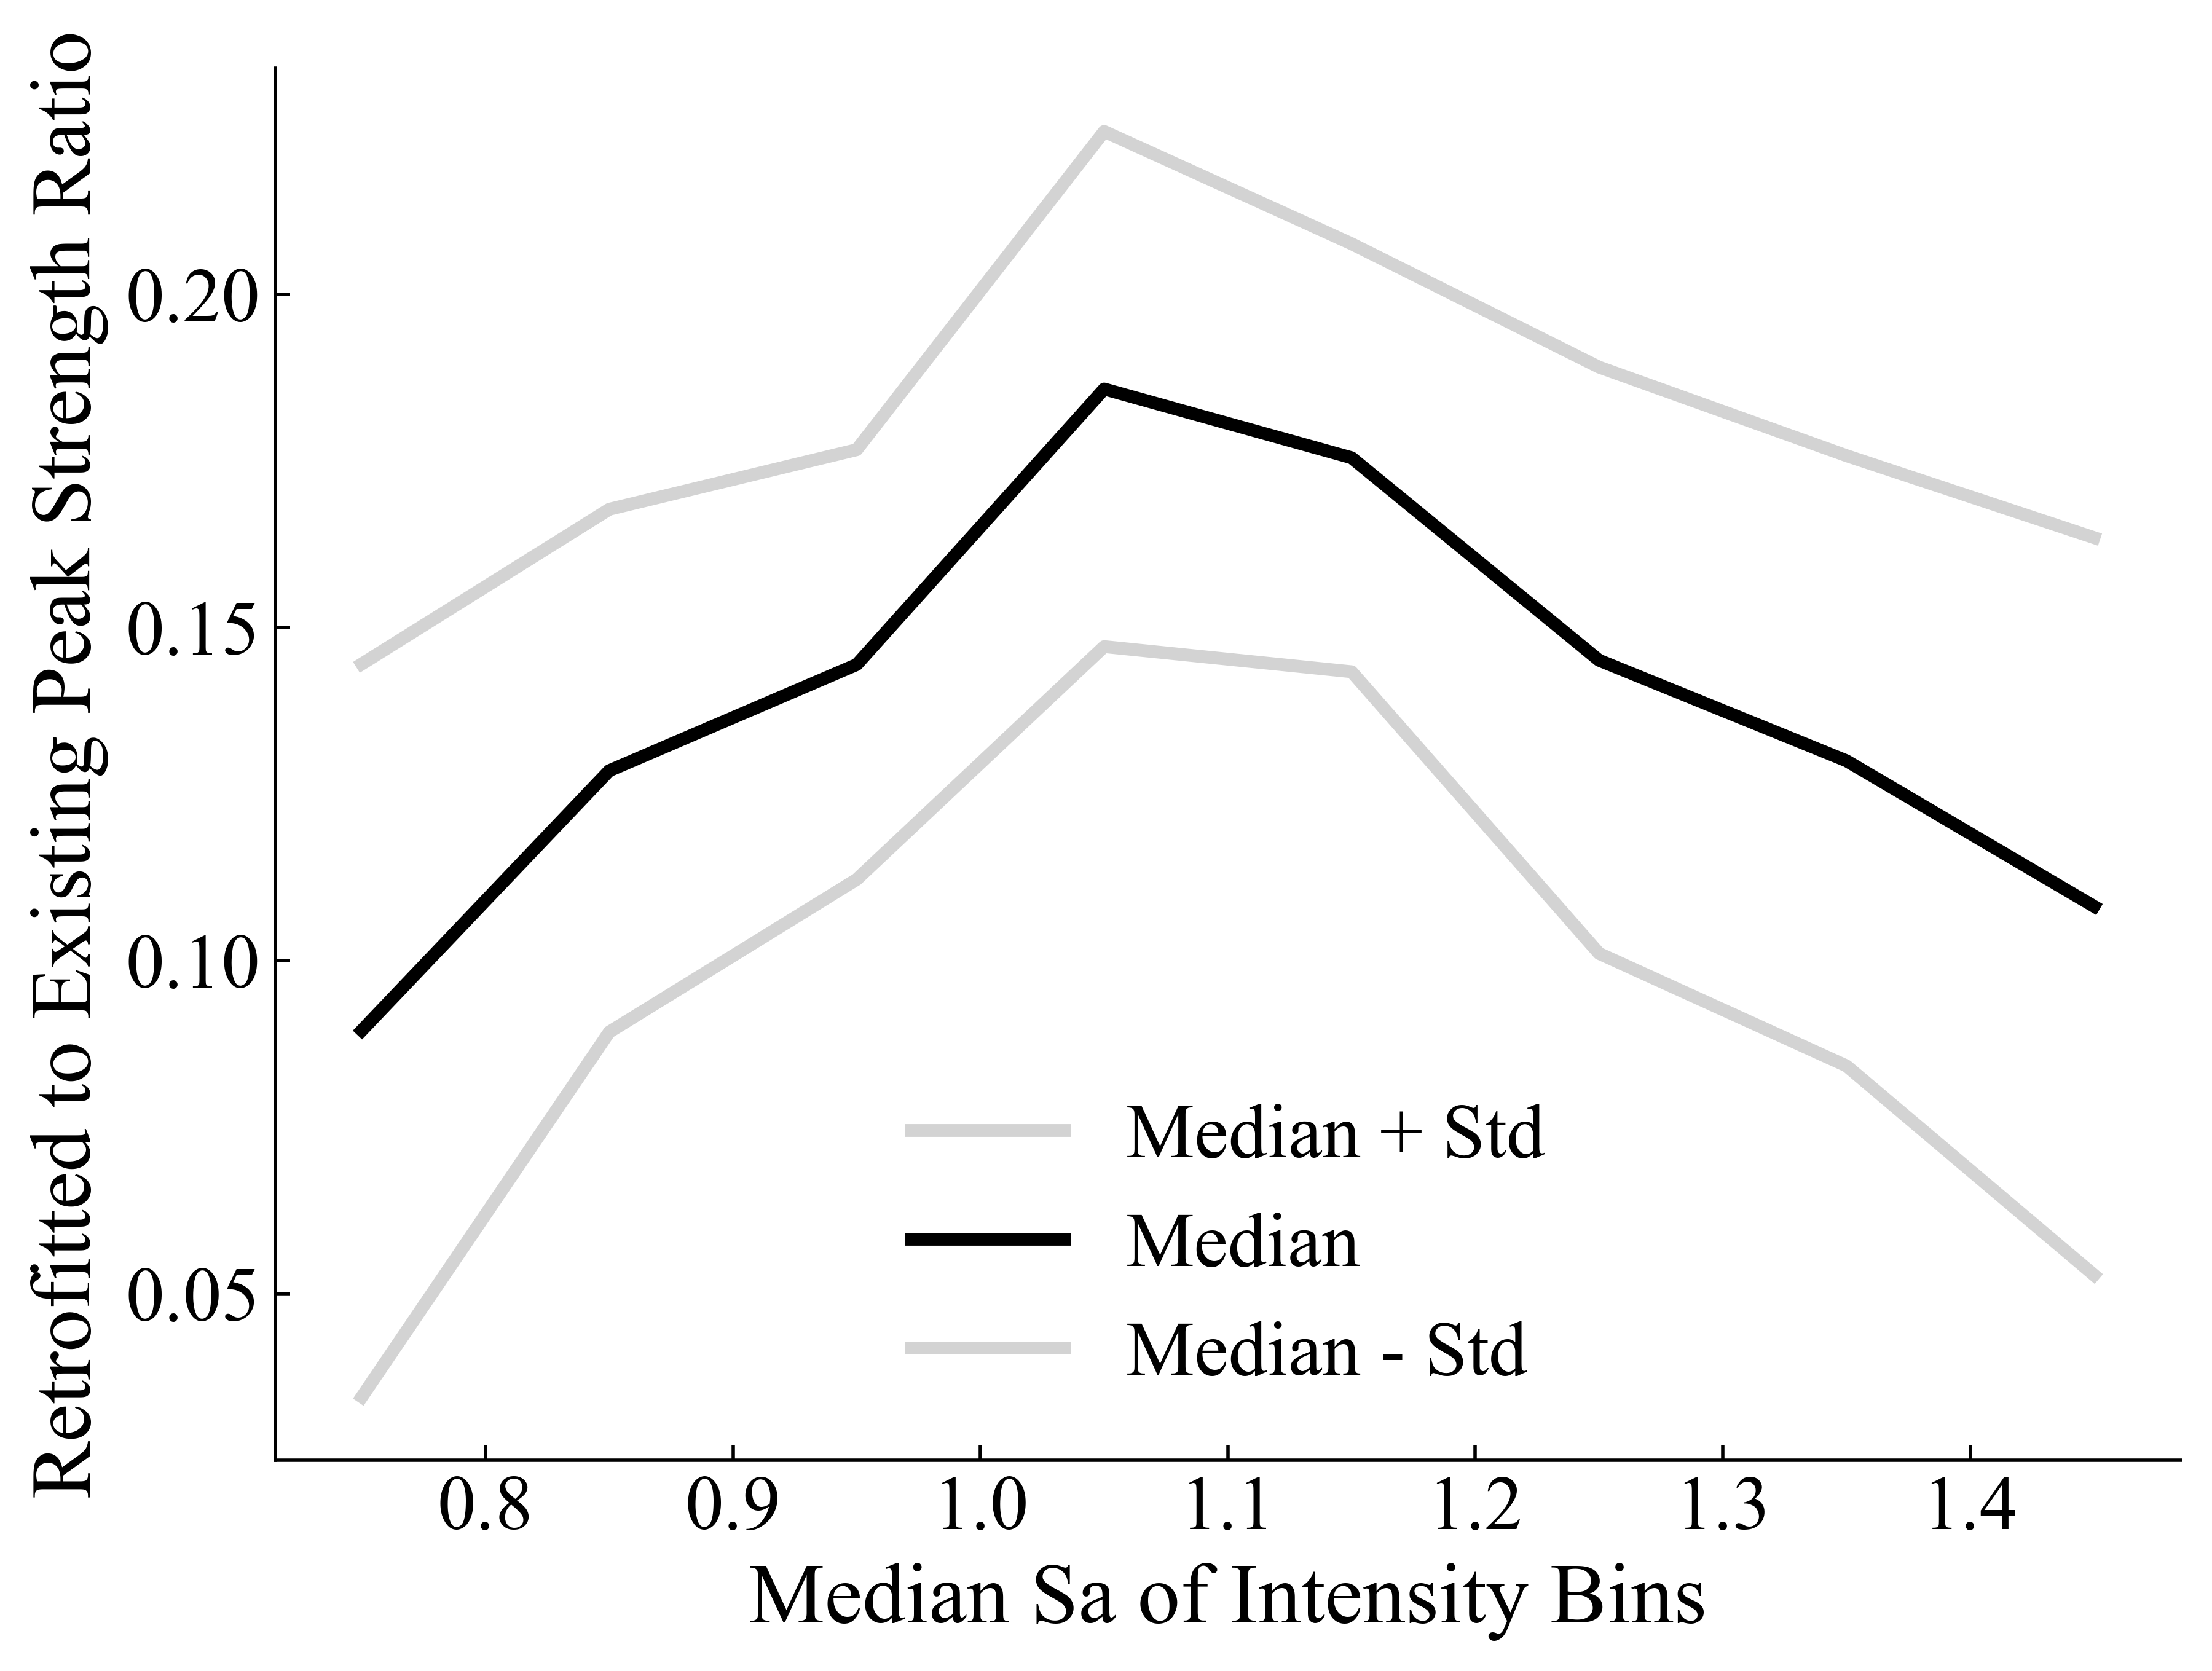

In [30]:
fig, ax = plt.subplots(figsize=(8,6), dpi=500)
font = {'fontname':'Times New Roman', 'size' : 20}

# for i in range(200):
#     ax.scatter([0.75, 0.85, 0.95, 1.05, 1.15, 1.25, 1.35, 1.45], list(x_bests.iloc[i,:].values), color='grey')
ax.plot([0.75, 0.85, 0.95, 1.05, 1.15, 1.25, 1.35, 1.45], (sensitivity_results[300000].median(axis = 0).values)+sensitivity_results[300000].std(axis = 0).values, color = 'lightgrey', linewidth = 3, label = 'Median + Std')
ax.plot([0.75, 0.85, 0.95, 1.05, 1.15, 1.25, 1.35, 1.45], (sensitivity_results[300000].median(axis = 0).values), color = 'black', linewidth = 3, label = 'Median')
ax.plot([0.75, 0.85, 0.95, 1.05, 1.15, 1.25, 1.35, 1.45],  (sensitivity_results[300000].median(axis = 0).values)-sensitivity_results[300000].std(axis = 0).values, color = 'lightgrey', linewidth = 3, label = 'Median - Std')
plt.xlabel('Median Sa of Intensity Bins', **font)
plt.ylabel('Retrofitted to Existing Peak Strength Ratio', **font)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
plt.xticks(fontname = 'Times New Roman', fontsize = 18)
plt.yticks(fontname = 'Times New Roman', fontsize = 18)
plt.locator_params(axis='y', nbins=6)
plt.legend(frameon = False, prop =  {"family":'Times New Roman', "size":18})
sns.despine()

In [9]:
def algorithm_added_strength(peakstrength_ratio, sampled_building_info, Sa_map, peak_strength, IM_bin):
    '''
    This function is developed for compute the total strength added by algorithm
    '''
    buildings = pd.DataFrame(data = sampled_building_info['Index'])
    cost_map = pd.DataFrame(np.zeros(Sa_map.shape))
    peak_strength_temp = peak_strength.copy()
    peak_strength_temp.iloc[16:24,1] = 0
    for k in range(8):
        temp = pd.DataFrame() 
        temp['Index'] = existing_prop['Index']
        temp['Total Force'] = np.multiply(peakstrength_ratio[k]-1, peak_strength_temp['Xpeakstrength']) + np.multiply(peakstrength_ratio[k]-1, peak_strength_temp['Zpeakstrength']) 
        for j in range(Sa_map.shape[1]):
            sub_Sa_map = Sa_map.loc[(Sa_map.iloc[:,j] < IM_bin[k+1]) & (Sa_map.iloc[:,j] >= IM_bin[k]), :].iloc[:,j]
            if sub_Sa_map.shape[0] == 0: 
                continue
            sub_building_map = buildings.loc[(Sa_map.iloc[:,j] < IM_bin[k+1]) & (Sa_map.iloc[:,j] >= IM_bin[k]),:]
            building_cost = sub_building_map.merge(temp, how = 'left')
            cost_map.loc[(Sa_map.iloc[:,j] < IM_bin[k+1]) & (Sa_map.iloc[:,j] >= IM_bin[k]), j] = building_cost.iloc[:,1].values

    total_cost =  cost_map.mean(axis = 1).sum()
    return total_cost

In [14]:
im_bin = [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, float('inf')]
SMS_bin = [0, 1.601, 1.8, 1.995, 2.2, 2.4, 2.6, 2.801, 3.0]
retrof_ratio = {}
prop = {}
retrof_ds_ratio = {}
retrof_ds_median = {}
# percentage_miss_strength = np.median(x_bests, axis = 0)
# t = [int(p/0.05)*0.05 for p in percentage_miss_strength]
percentage_peak_strength = list(x_best)

for i in range(1,9):
    temp = pd.DataFrame() 
    temp['Index'] = existing_prop['Index']
    temp['Xpeakstrength'] = percentage_peak_strength[i-1]
    temp['Zpeakstrength'] = percentage_peak_strength[i-1]

    retrof_ratio[i] = pd.concat([temp, retrof_upper_limit]).min(level=0)
    prop[i] = existing_prop.drop(['Xpeakstrength', 'Zpeakstrength'], axis = 1)
    prop[i]['Xpeakstrength'], prop[i]['Zpeakstrength'] = retrof_ratio[i]['Xpeakstrength'].copy(), retrof_ratio[i]['Zpeakstrength'].copy()

    retrof_ds_ratio[i] = pd.DataFrame(data = prop[i]['Index'])
    retrof_ds_ratio[i]['complete_ratio'] = retrof_complete_ratio.predict(prop[i].iloc[:,1:])
    # Compute retrofitted buildings damage state medians 
    retrof_ds_median[i] = pd.DataFrame(data = np.multiply(retrof_ds_ratio[i]['complete_ratio'],existing_ds['Complete']))
    retrof_ds_median[i].insert(0,'Index', retrof_ds_ratio[i]['Index'])

Algorithm_closs, Algorithm_closs_individual = compute_closs(sampled_building_info, building_loss, retrof_ds_median, pd.DataFrame(data = sampled_building_info['SMS']), sa, SMS_bin)
Algorithm_closs_ph, Algorithm_closs_individual_ph = compute_closs(sampled_building_info, building_loss, retrof_ds_median, pd.DataFrame(data = sampled_building_info['SMS']), sa_puentehill, SMS_bin)

Algorithm_cost =  algorithm_added_strength(percentage_peak_strength, sampled_building_info, pd.DataFrame(data = sampled_building_info['SMS']), peak_strength, SMS_bin)

# Ordinance Performance Evaluation

In [8]:
def actual_building_loss(sampled_building_info, building_loss, building_dsm, Sa_map):
    '''    
    This function is mainly used for computing regional earthquake losses given scenario
    sampled_building_info: assigned missing building information 
    building_loss: prototype archetype losses in each damage state 
    building_dsm: retrofitted prototype archetype damage state medians 
    Sa_map: ground shaking maps given scenario/event
    '''
    buildings = pd.DataFrame(data = sampled_building_info['Index'])
    # Building collapse  at each location
    site_loss = buildings.merge(building_loss, how = 'left')

    # Building damage state median at each location 
    building_ds_median = buildings.merge(building_dsm, how = 'left')

    # Compute probability of complete damage at each site given each shake map
    ds_prob_map = pd.DataFrame(np.zeros(Sa_map.shape))
    # Loop over all shake maps
    for j in range(Sa_map.shape[1]):
        ds_prob_map.iloc[:,j] = norm.cdf(np.log(Sa_map.iloc[:,j]), loc = np.log(building_ds_median.iloc[:,1]), scale = 0.6)
    collapse_prob = ds_prob_map.mean(axis = 1)

    portfolio_loss = np.multiply(collapse_prob,site_loss.iloc[:,1]).sum()
    individual_loss =  sampled_building_info[['Latitude', 'Longitude']]
    individual_loss['Loss'] = np.multiply(collapse_prob,site_loss.iloc[:,1]).values
    return portfolio_loss, individual_loss

def ordinance_added_strength(sampled_building_info, added_strength):
    buildings = pd.DataFrame(data = sampled_building_info['Index'])
    # Building collapse  at each location
    site_cost = buildings.merge(added_strength, how = 'left')
    return site_cost.iloc[:,1].sum()


In [49]:
Existing_closs, Existing_closs_individual = actual_building_loss(sampled_building_info, total_loss, existing_ds, sa)
Existing_closs_ph, Existing_closs_individual_ph = actual_building_loss(sampled_building_info, total_loss, existing_ds, sa_puentehill)

Algorithm_reduction = 1-Algorithm_closs/Existing_closs 
print('Algorithm reduces the loss by %.4f'%Algorithm_reduction)
Algorithm_reduction = 1-Algorithm_closs_ph/Existing_closs_ph
print('Algorithm reduces the Puente Hill loss by %.4f'%Algorithm_reduction)


Algorithm reduces the loss by 0.2070
Algorithm reduces the Puente Hill loss by 0.1117


In [50]:
ordinance_ds = pd.read_csv(r'C:\Users\User\Desktop\FinalFinalOptimization\OrdinancePerformance\CollapseMedian.csv')
ordinance_retrof_strength = pd.read_csv(r'C:\Users\User\Desktop\FinalFinalOptimization\OrdinancePerformance\OrdinanceStrengthInc.csv')
SMS_bin = [0, 1.601, 1.8, 1.995, 2.2, 2.4, 2.6, 2.801, 3.0]
Ordinance_closs = 0
Ordinance_cost = 0
Ordinance_closs_individual = pd.DataFrame(columns=['Index','Loss'])
Ordinance_closs_ph = 0
Ordinance_closs_individual_ph = pd.DataFrame(columns=['Index','Loss'])

for i in range(8):
    sub_building_map = sampled_building_info.loc[(sampled_building_info['SMS'] < SMS_bin[i+1]) & (sampled_building_info['SMS'] >= SMS_bin[i]),:]
    sub_sa_map = sa.loc[(sampled_building_info['SMS'] < SMS_bin[i+1]) & (sampled_building_info['SMS'] >= SMS_bin[i]),:]
    sub_building_map_ph = sampled_building_info.loc[(sampled_building_info['SMS'] < SMS_bin[i+1]) & (sampled_building_info['SMS'] >= SMS_bin[i]),:]
    sub_sa_map_ph = sa_puentehill.loc[(sampled_building_info['SMS'] < SMS_bin[i+1]) & (sampled_building_info['SMS'] >= SMS_bin[i]),:]

    or_dsm = ordinance_ds[['Index','%i'%i]]
    sub_building_map_closs, sub_building_individual_loss = actual_building_loss(sub_building_map, total_loss, or_dsm, sub_sa_map)
    sub_building_map_closs_ph, sub_building_individual_loss_ph = actual_building_loss(sub_building_map_ph, total_loss, or_dsm, sub_sa_map_ph)

    Ordinance_closs_individual = Ordinance_closs_individual.append(sub_building_individual_loss)
    Ordinance_closs += sub_building_map_closs

    Ordinance_closs_individual_ph = Ordinance_closs_individual_ph.append(sub_building_individual_loss_ph)
    Ordinance_closs_ph += sub_building_map_closs_ph
    Ordinance_cost += ordinance_added_strength(sub_building_map, ordinance_retrof_strength[['Index','%i'%i]])


Ordinance_reduction = 1-Ordinance_closs/Existing_closs 
print('Ordinance reduces the loss by %.4f'%Ordinance_reduction)
Ordinance_reduction = 1-Ordinance_closs_ph/Existing_closs_ph
print('Ordinance reduces the Puente Hill loss by %.4f'%Ordinance_reduction)
print('Algorithm uses %.4f strength of Ordinance retrofit'%(Algorithm_cost/Ordinance_cost))

Ordinance reduces the loss by 0.2943
Ordinance reduces the Puente Hill loss by 0.1668
Algorithm uses 0.6205 strength of Ordinance retrofit


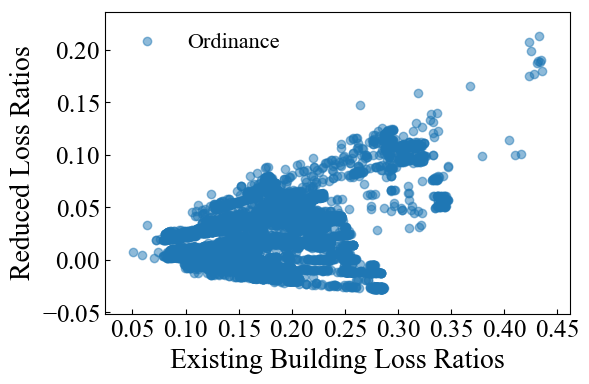

In [37]:
# Read in and stack 20 representative scenarios 
ids = [98,635,969,2177,3110,4393,4520,5278,5575,5675,5846,6403,6965,7396,7572,7604,7681,7718,8033,8294]
scenario_loss = pd.DataFrame(index=ids, columns=['Existing', 'Algorithm Retrofitted', 'Algorithm Reduction', 'Ordinance Retrofitted','Ordinance Reduction'])
for i in ids:
    os.chdir(r'D:\Google Drive\Research\Ph.D. Topic Research\Cost_Benefit\UCERF2_Event_Processed_Data\Clustered Events\Event%i'%i)
    temp = pd.read_csv('sa_simulated.csv', index_col=0)

    sa = pd.concat([sa, temp], axis = 1)

In [24]:
# stacked events results
results_multievents = Algorithm_closs_individual.copy()
results_multievents = results_multievents.rename(columns={'Loss':'Algorithm Loss'})
# normalized loss ratios 
results_multievents['Algorithm Loss'] = np.divide(results_multievents['Algorithm Loss'].values, sampled_building_info['Area'].values * 200)
results_multievents['Ordinance Loss'] = np.divide(Ordinance_closs_individual.sort_index()['Loss'].values, sampled_building_info['Area'].values * 200)
results_multievents['Existing Loss'] = np.divide(Existing_closs_individual['Loss'].values, sampled_building_info['Area'].values * 200)

results_multievents['Algorithm to Ordinance Ratio'] = np.divide(results_multievents['Algorithm Loss'].values, results_multievents['Ordinance Loss'].values)
results_multievents['Algorithm to Existing Ratio'] = np.divide(results_multievents['Algorithm Loss'].values, results_multievents['Existing Loss'].values)
results_multievents['Ordinance to Existing Ratio'] = np.divide(results_multievents['Ordinance Loss'].values, results_multievents['Existing Loss'].values)
results_multievents['Algorithm Reduction'] = 1 - np.divide(results_multievents['Algorithm Loss'].values, results_multievents['Existing Loss'].values)
results_multievents['Ordinance Reduction'] = 1 - np.divide(results_multievents['Ordinance Loss'].values, results_multievents['Existing Loss'].values)
results_multievents.to_csv(r'C:\\Users\\User\\Desktop\\FinalFinalOptimization\\Optimization_MultiScenarios\\LossMap\\multievents.csv')

# puente hill event results
ph_multievents = Algorithm_closs_individual_ph.copy()
ph_multievents = ph_multievents.rename(columns={'Loss':'Algorithm Loss'})
ph_multievents['Algorithm Loss'] = np.divide(ph_multievents['Algorithm Loss'].values, sampled_building_info['Area'].values * 200)
ph_multievents['Ordinance Loss'] = np.divide(Ordinance_closs_individual_ph.sort_index()['Loss'].values, sampled_building_info['Area'].values * 200)
ph_multievents['Existing Loss'] = np.divide(Existing_closs_individual_ph['Loss'].values, sampled_building_info['Area'].values * 200)

ph_multievents['Algorithm to Ordinance Ratio'] = np.divide(ph_multievents['Algorithm Loss'].values, ph_multievents['Ordinance Loss'].values)
ph_multievents['Algorithm to Existing Ratio'] = np.divide(ph_multievents['Algorithm Loss'].values, ph_multievents['Existing Loss'].values)
ph_multievents['Ordinance to Existing Ratio'] = np.divide(ph_multievents['Ordinance Loss'].values, ph_multievents['Existing Loss'].values)
ph_multievents['Algorithm Reduction'] = 1 - np.divide(ph_multievents['Algorithm Loss'].values, ph_multievents['Existing Loss'].values)
ph_multievents['Ordinance Reduction'] = 1 - np.divide(ph_multievents['Ordinance Loss'].values, ph_multievents['Existing Loss'].values)
ph_multievents.to_csv(r'C:\\Users\\User\\Desktop\\FinalFinalOptimization\\Optimization_MultiScenarios\\LossMap\\puentehill.csv')

In [38]:
#Perform evaluation for 100 sampled building archetype distribution 
A_Loss, A_Cost = [], []
O_Loss, O_Cost = [], []
E_Loss = []

for g in range(100):
    sampled_building_info = samplecase(OriginalBuildingInfo)

    im_bin = [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, float('inf')]
    retrof_ratio = {}
    prop = {}
    retrof_ds_ratio = {}
    retrof_ds_median = {}
    percentage_miss_strength = np.median(x_bests, axis = 0)
    min_strength_retrof_peakstrength = pd.read_csv(r'C:\Users\User\Desktop\FinalOptimization\Optimization_AllArchetypes\min_strength_pushoverstrength.csv')
    t = [int(p/0.05)*0.05 for p in percentage_miss_strength]
    percentage_miss_strength = t
    for i in range(1,9):
        temp = pd.DataFrame() 
        temp['Index'] = existing_prop['Index']
        temp['Xpeakstrength'] = np.divide(np.multiply(percentage_miss_strength[i-1], missing_strength['X Diff']) + peak_strength['Xpeakstrength'], peak_strength['Xpeakstrength']) + percentage_miss_strength[8] * min_strength_retrofit_indicator['X']
        temp['Zpeakstrength'] = np.divide(np.multiply(percentage_miss_strength[i-1], missing_strength['Z Diff']) + peak_strength['Zpeakstrength'], peak_strength['Zpeakstrength']) + percentage_miss_strength[8] * min_strength_retrofit_indicator['Z']
        retrof_ratio[i] = temp
        prop[i] = existing_prop.drop(columns=['Xpeakstrength', 'Zpeakstrength'])
        prop[i]['Xpeakstrength'], prop[i]['Zpeakstrength'] = retrof_ratio[i]['Xpeakstrength'], retrof_ratio[i]['Zpeakstrength']

        retrof_ds_ratio[i] = pd.DataFrame(data = prop[i]['Index'])
        retrof_ds_ratio[i]['complete_ratio'] = retrof_complete_ratio.predict(prop[i].iloc[:,1:])
        # Compute retrofitted buildings damage state medians 
        retrof_ds_median[i] = pd.DataFrame(data = np.multiply(retrof_ds_ratio[i]['complete_ratio'],existing_ds['Complete']))
        retrof_ds_median[i].insert(0,'Index', retrof_ds_ratio[i]['Index'])

    Algorithm_closs, Algorithm_closs_individual = compute_closs(sampled_building_info, building_loss, retrof_ds_median, sa_simulated, im_bin)
    Algorithm_cost =  algorithm_added_strength(percentage_miss_strength, sampled_building_info, sa_simulated, missing_strength,min_strength_retrof_peakstrength, im_bin)
    A_Loss.append(Algorithm_closs)
    A_Cost.append(Algorithm_cost)

    Existing_closs, _ = actual_building_loss(sampled_building_info, total_loss, existing_ds, sa_simulated)
    E_Loss.append(Existing_closs)

    Ordinance_closs = 0
    Ordinance_cost = 0
    for i in range(8):
        sub_building_map = sampled_building_info.loc[(sampled_building_info['SMS'] <= SMS_bin[i+1]) & (sampled_building_info['SMS'] > SMS_bin[i]),:]
        sub_sa_map = sa_simulated.loc[(sampled_building_info['SMS'] <= SMS_bin[i+1]) & (sampled_building_info['SMS'] > SMS_bin[i]),:]
        or_dsm = ordinance_ds[['Index','%i'%i]]
        sub_building_map_closs, _ = actual_building_loss(sub_building_map, total_loss, or_dsm, sub_sa_map)
        Ordinance_closs += sub_building_map_closs
        Ordinance_cost += ordinance_added_strength(sub_building_map, ordinance_retrof_strength[['Index','%i'%i]])

    O_Loss.append(Ordinance_closs)
    O_Cost.append(Ordinance_cost)

In [39]:
print(np.mean(A_Cost)/np.mean(O_Cost))
print(np.mean(A_Loss)/np.mean(O_Loss))
print((np.mean(A_Loss)-np.mean(E_Loss))/(np.mean(O_Loss)-np.mean(E_Loss)))

4.765020828596307
19.80697873118936
0.08717677013136971


# Sensitivity Results


In [11]:
median_bests = [sensitivity_results[i].median(axis = 0).values for i in sensitivity_results.keys()]

In [12]:
algorithm_cost_sens, algorithm_loss_sens = [], []
im_bin = [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, float('inf')]
SMS_bin = [0, 1.601, 1.8, 1.995, 2.2, 2.4, 2.6, 2.801, 3.0]
algorithm_loss_sens = []
algorithm_cost_sens = []
for x in median_bests:
    retrof_ratio = {}
    prop = {}
    retrof_ds_ratio = {}
    retrof_ds_median = {}
    percentage_peak_strength = list(x)

    for i in range(1,9):
        temp = pd.DataFrame() 
        temp['Index'] = existing_prop['Index']
        temp['Xpeakstrength'] = percentage_peak_strength[i-1]
        temp['Zpeakstrength'] = percentage_peak_strength[i-1]

        retrof_ratio[i] = pd.concat([temp, retrof_upper_limit]).min(level=0)
        prop[i] = existing_prop.drop(['Xpeakstrength', 'Zpeakstrength'], axis = 1)
        prop[i]['Xpeakstrength'], prop[i]['Zpeakstrength'] = retrof_ratio[i]['Xpeakstrength'].copy(), retrof_ratio[i]['Zpeakstrength'].copy()

        retrof_ds_ratio[i] = pd.DataFrame(data = prop[i]['Index'])
        retrof_ds_ratio[i]['complete_ratio'] = retrof_complete_ratio.predict(prop[i].iloc[:,1:])
        # Compute retrofitted buildings damage state medians 
        retrof_ds_median[i] = pd.DataFrame(data = np.multiply(retrof_ds_ratio[i]['complete_ratio'],existing_ds['Complete']))
        retrof_ds_median[i].insert(0,'Index', retrof_ds_ratio[i]['Index'])

    al, _ = compute_closs(sampled_building_info, building_loss, retrof_ds_median, pd.DataFrame(data = sampled_building_info['SMS']), sa, SMS_bin)
    algorithm_loss_sens.append(al)
    ac =  algorithm_added_strength(percentage_peak_strength, sampled_building_info, sa_simulated, peak_strength, im_bin)
    algorithm_cost_sens.append(ac)

Existing_closs, Existing_closs_individual = actual_building_loss(sampled_building_info, total_loss, existing_ds, sa_simulated)

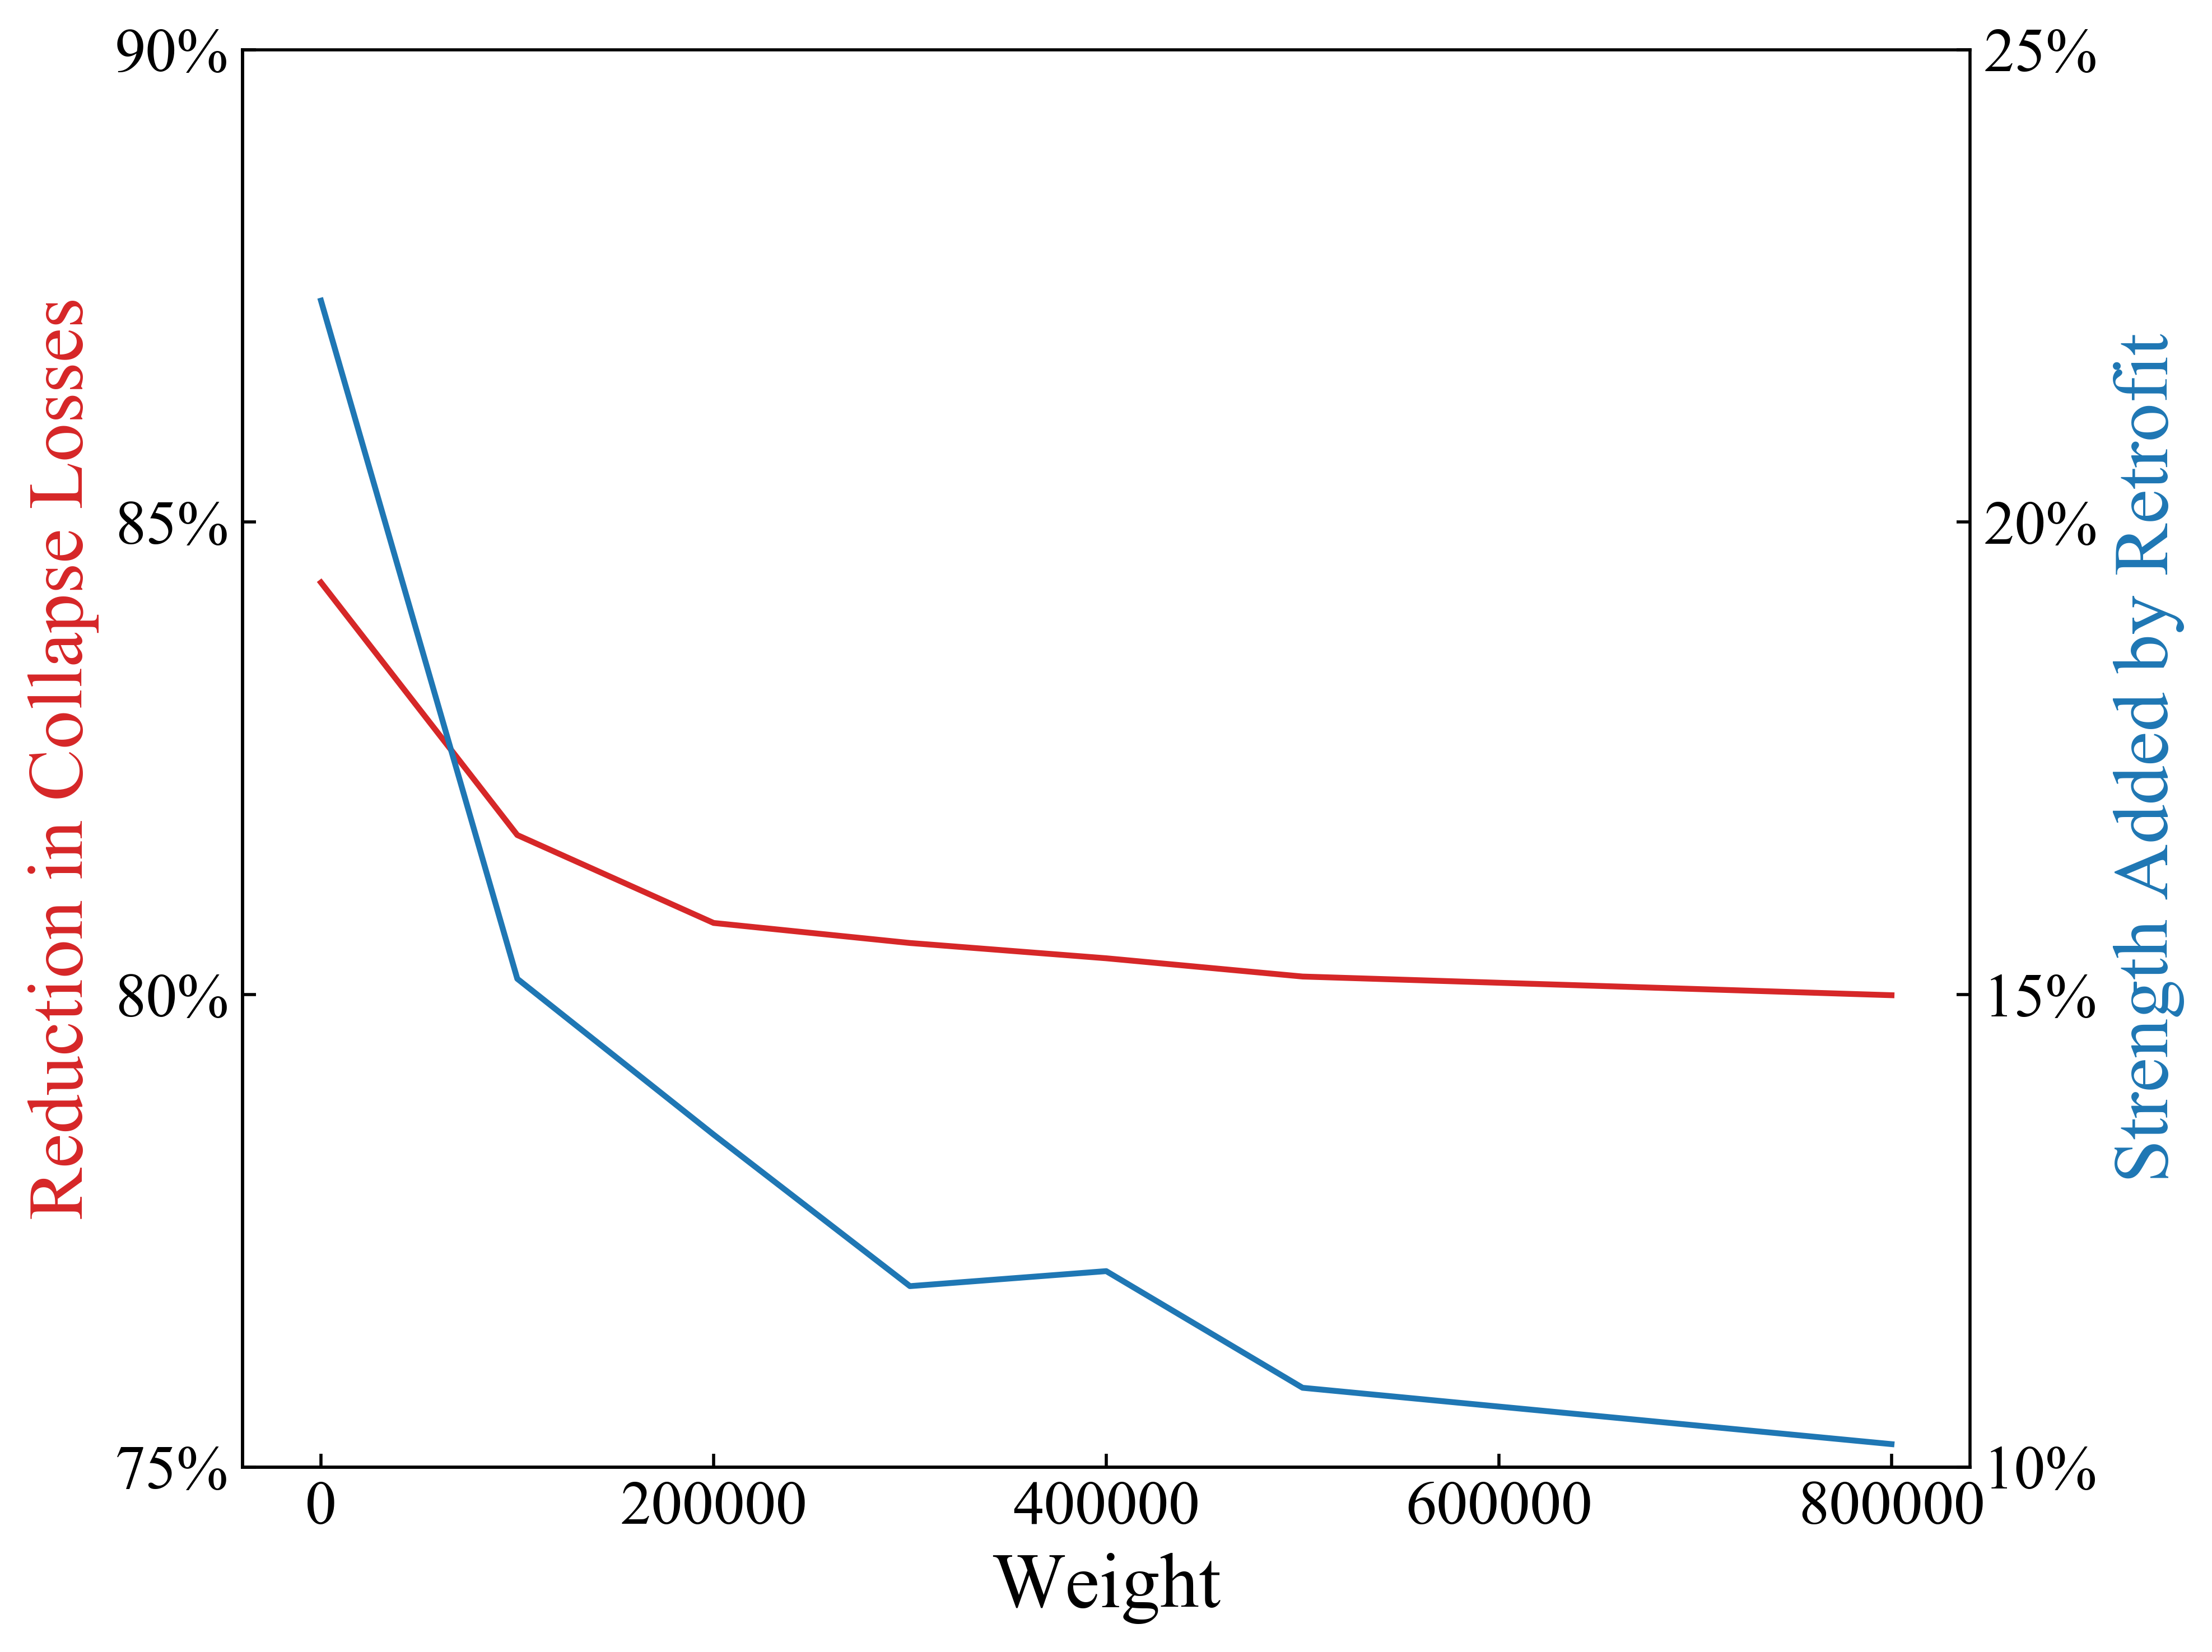

&lt;Figure size 432x288 with 0 Axes&gt;

In [15]:
fig, ax1 = plt.subplots(figsize=(8,6), dpi=500)
font = {'fontname':'Times New Roman', 'size' : 20}
import matplotlib.ticker as mtick

color = 'tab:red'
ax1.set_xlabel('Weight', **font)
ax1.set_ylabel('Reduction in Collapse Losses', color=color, **font)
ax1.plot(W[:7], [(1-algorithm_loss_sens[i]/Existing_closs)*100 for i in range(7)], color=color)
sns.despine()
for label in ax1.get_xticklabels():
    label.set_fontproperties('Times New Roman')
for label in ax1.get_yticklabels():
    label.set_fontproperties('Times New Roman')

ax1.tick_params(axis="y",direction="in", labelsize = 16)
ax1.set_ylim([75, 90])
fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
ax1.yaxis.set_major_formatter(yticks)

ax1.tick_params(axis="x",direction="in", labelsize = 16)
plt.locator_params(axis='x', nbins=6)
plt.locator_params(axis='y', nbins=4)
 
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

existing_building_strength = sampled_building_info[['Index']].merge(peak_strength, how = 'left', on = 'Index')['Xpeakstrength'].sum() + sampled_building_info[['Index']].merge(peak_strength, how = 'left', on = 'Index')['Zpeakstrength'].sum()

color = 'tab:blue'
ax2.plot(W[:7], [algorithm_cost_sens[i]/existing_building_strength*100 for i in range(7)], color=color)
ax2.tick_params(axis='y', direction = 'in', labelsize = 14)
ax2.set_ylabel('Strength Added by Retrofit', color=color, **font)

for label in ax2.get_yticklabels():
    label.set_fontproperties('Times New Roman')
ax2.tick_params(axis="y",direction="in", labelsize = 16)
ax2.set_ylim([10, 25])
fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
ax2.yaxis.set_major_formatter(yticks)

plt.locator_params(axis='y', nbins=4)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
sns.despine()

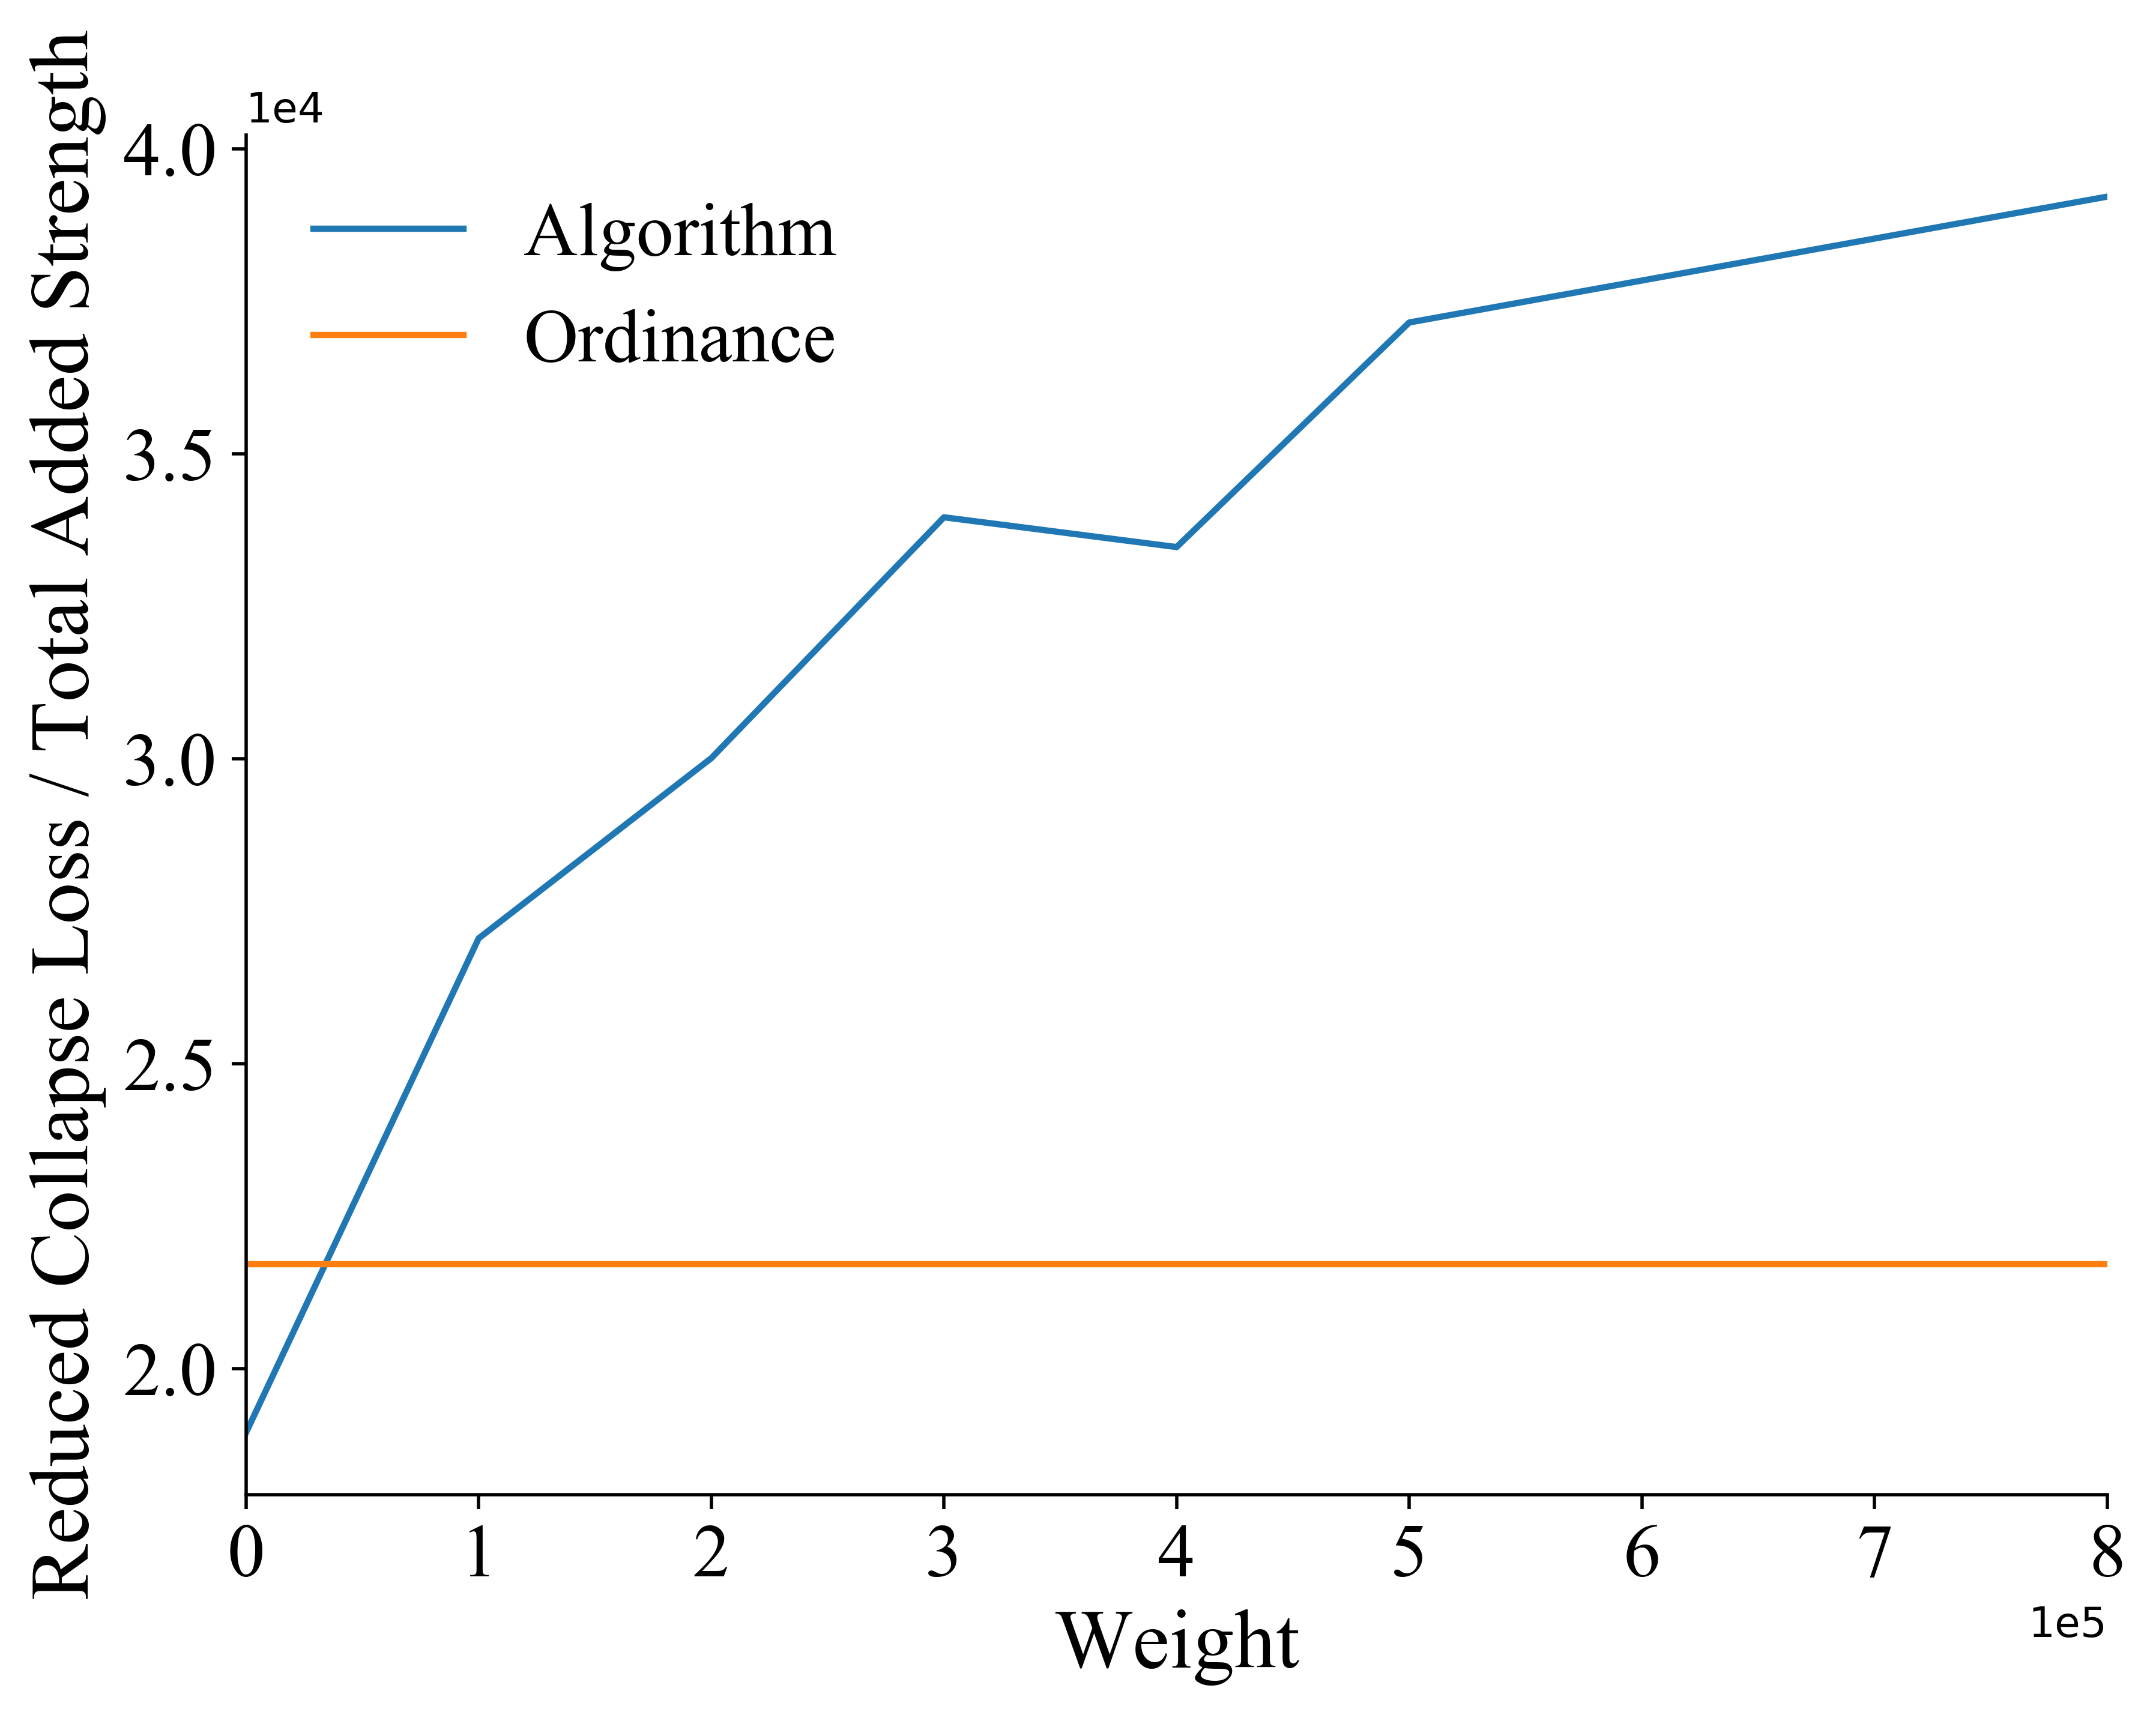

<Figure size 432x288 with 0 Axes>

In [134]:
fig, ax = plt.subplots(figsize=(8,6), dpi=500)
font = {'fontname':'Times New Roman', 'size' : 20}

plt.xlabel('Weight', **font)
plt.ylabel('Reduced Collapse Loss / Total Added Strength',  **font)
plt.plot(W[:7], [(Existing_closs-algorithm_loss_sens[i])/(algorithm_cost_sens[i]) for i in range(7)], label = 'Algorithm')
plt.plot(W[:7], [(Existing_closs-Ordinance_closs)/(Ordinance_cost) for i in range(7)], label = 'Ordinance')
plt.legend(frameon = False, prop =  {"family":'Times New Roman', "size":18})
plt.xticks(fontname = 'Times New Roman', fontsize = 18)
plt.yticks(fontname = 'Times New Roman', fontsize = 18)
plt.ticklabel_format(axis='both', style='sci', scilimits=(4,4))

sns.despine()
# ax.set_xscale('log')
plt.locator_params(axis='y', nbins=5)
plt.xlim(0, 8e5)
# ax1.set_yscale('log')
# ax1.set_ylim([0, 3e-6])
plt.show()
sns.despine()

In [78]:
[(1-algorithm_loss_sens[i]/Existing_closs)/(algorithm_cost_sens[i]) for i in range(7)]

[5.323049443217745e-07,
 5.48343476570671e-07,
 5.230743821787296e-07,
 5.700018517847763e-07,
 5.436078364116106e-07,
 5.826168570446766e-07,
 5.897239636471526e-07]

In [86]:
(1-Algorithm_closs/Existing_closs)/(Algorithm_cost)

5.700018517847763e-07

In [79]:
(1-Ordinance_closs/Existing_closs)/(Ordinance_cost)

6.734740128008178e-07

In [84]:
Algorithm_closs/Ordinance_cost

5115.088237531788

In [87]:
1-Ordinance_closs/Existing_closs

0.294103598422669

In [88]:
1-Algorithm_closs/Existing_closs

0.20690749005953946

In [137]:
Ordinance_closs_ph

6584303096.975963